In [22]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import os
plt.rcParams["figure.figsize"]=14,5
import holidays
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import sys
import datetime


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import requests
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
# logger.info(f"tf version:{tf.__version__}")
# from tensorflow import keras
from tensorflow.keras.regularizers import l2                # type: ignore
from tensorflow.keras.optimizers import Adam                # type: ignore
# from tensorflow.keras import Sequential                   # type: ignore
# from tensorflow.keras.layers import LSTM, Dropout, Dense  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping        # type: ignore
from tensorflow.keras import layers                         # type: ignore
from tensorflow.keras.models import Sequential              # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout    # type: ignore
from tensorflow.keras import regularizers                   # type: ignore
# from sklearn.inspection import permutation_importance
np.set_printoptions(precision=3, suppress=True)
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from math import sqrt


In [57]:
df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
df = df.copy()

df.drop("sensor", axis=1, inplace=True)
print(f"df rows: {len(df)}")
print(f"Duplicated rows: {df.duplicated().sum()}")
df.set_index("creation_time", drop=True, inplace=True)
df = df.loc[df.index.year>2022]
df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
df = df.drop_duplicates()
df = df[df['R_Voltage'] != 0]
# df = df.loc[~df['R_Voltage'] == 0]
print(f"Duplicated index: {df.index.duplicated().sum()}")
print(f"null_values : {df.isna().sum().sum()}")
print(f"df rows after basic checks: {len(df)}")
df

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 38
Duplicated index: 0
null_values : 0
df rows after basic checks: 24777


,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,KWh
creation_time,,,,,,,
2023-01-01 00:00:00,6392.0,6352.0,6397.0,5.02,5.68,5.09,48.3
2023-01-01 00:30:00,6418.0,6379.0,6426.0,4.39,5.14,4.82,42.7
2023-01-01 01:00:00,6418.0,6380.0,6428.0,4.81,3.78,5.11,40.4
2023-01-01 01:30:00,6436.0,6399.0,6449.0,3.49,3.06,4.05,29.6
2023-01-01 02:00:00,6447.0,6411.0,6460.0,3.69,3.26,4.27,32.1
...,...,...,...,...,...,...,...
2024-05-31 21:30:00,6266.0,6296.0,6294.0,24.90,24.04,25.35,228.3
2024-05-31 22:00:00,6228.0,6256.0,6256.0,26.73,25.31,24.82,235.3
2024-05-31 22:30:00,6215.0,6248.0,6241.0,27.74,27.69,26.61,252.0


null vlaues after resampling: 39
null values after filling: 0


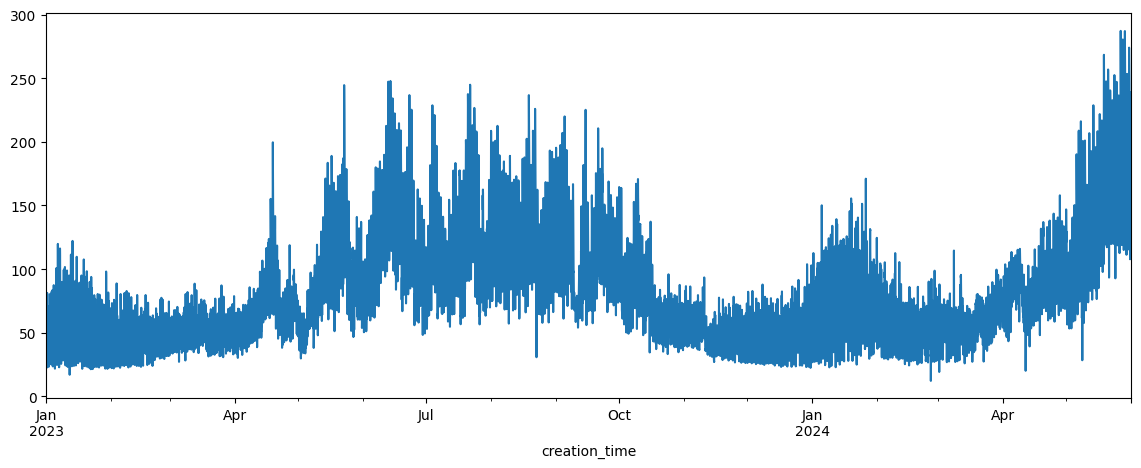

,KWh
creation_time,
2023-01-01 00:00:00,NaN
2023-01-01 00:30:00,NaN
2023-01-01 01:00:00,NaN
2023-01-01 01:30:00,40.250
2023-01-01 02:00:00,36.200
...,...
2024-05-31 21:30:00,184.975
2024-05-31 22:00:00,205.225
2024-05-31 22:30:00,228.850


In [58]:
resample_df = df[['KWh']].resample(rule="30min").asfreq()
print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
# resample_df[resample_df.isna().any(axis=1)]
resample_df = resample_df.interpolate(method="linear")
print(f"null values after filling: {resample_df.isna().sum().sum()}")
resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
resample_df['KWh'].plot()
plt.show()
resample_df

In [59]:
def data_ingestion(month):
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    df = df.loc[((df.index.year==2024) & ((df.index.month>=(month-2)) & (df.index.month<(month+1))))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def pre_process(data):
    main_df = data[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {main_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    main_df = main_df.interpolate(method="linear")
    print(f"null values after filling: {main_df.isna().sum().sum()}")
    # resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    main_df['KWh'].plot()
    plt.show()
    return main_df

def holidays_list(start_date, end_date):
    holiday_list = []
    india_holidays = holidays.CountryHoliday('India', years=start_date.year)
    # Iterate through each date from start_date to end_date
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a holiday in India or a Sunday
        if current_date in india_holidays or current_date.weekday() == 6:
            holiday_list.append(current_date)
        current_date += timedelta(days=1)

    return holiday_list


def correlation_matrix(df):
    correlation_matrix_data = df.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(18, 10))
    # Draw the heatmap
    sns.heatmap(correlation_matrix_data, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    # Show the plot
    plt.show()

def add_lags(dff, target_col, large_data= False):
    # target_map = dff['consumed_unit'].to_dict()
    target_map = dff[target_col].to_dict()

    # 1 Hour, 2 Hours, 6 Hours
    dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
    dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
    dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
    # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
    # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
    dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
    # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
    # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
    dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

    # if large_data:
    # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
    dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
    # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
        # logger.info(f" lags added for large data")
    #     return dff
    # else:
    
    dff['daily_avg'] = dff[target_col].rolling(window=48).mean()  # 24-hour rolling mean
    dff['weekly_avg'] = dff[target_col].rolling(window=7*48).mean()  # Weekly rolling mean


    # logger.info(f"lags added")
    return dff



def create_features(hourly_data,lagre_data= False):

    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
        
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['dayofyear'] = hourly_data.index.dayofyear
    # hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
    hourly_data['holiday'] = 0
    # if lagre_data:
    # hourly_data['month'] = hourly_data.index.month
    # hourly_data['quarter'] = hourly_data.index.quarter
    # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['year'] = hourly_data.index.year

    return hourly_data

def plot_prediction(actual, predicted,timestamp=False):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))

    # Plot actual values in red
    if timestamp:
        plt.plot(actual.index, actual, color='red', label='Actual Power')
        # Plot predicted values in blue
        plt.plot(actual.index, predicted, color='blue', label='Predicted Power')    

    else:
        plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
        # Plot predicted values in blue
        plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
        # Adding labels and title

    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()

def feature_engineering(dataframe, c_matrix=False):
    weather_df = pd.read_parquet("weather_data_2024_10_24.parquet")
    # latitude, longitude = "28.46072","77.537381" #"28.625361","77.376214"#, 28.628059,77.378912
    from_date = dataframe.first_valid_index().date()
    to_date = dataframe.last_valid_index().date()
    print("from_date: ",from_date,"to_date: ",to_date)

    holidays_lst= holidays_list(from_date,to_date)
    print("holidays_lst:",holidays_lst)
    df_lags = add_lags(dataframe,target_col="KWh")
    df_features = create_features(df_lags)
    for date in holidays_lst:
        df_features.loc[f"{date}", 'holiday'] = 1
    final_df = df_features.merge(weather_df,on=["creation_time"])
    # final_df.drop(['creation_time'],axis=1,inplace=True)
    # final_df.fillna(0,inplace= True)
    print(final_df.isna().sum())
    final_df.dropna(inplace=True)
    if c_matrix:
        correlation_matrix(final_df)
    return final_df

def feature_label(dataset,target_variable = "KWh"):
    # train 
    dataset_features = dataset.copy()   
    dataset_label = dataset_features.pop(target_variable)
    print(f"dataset_features shape: {dataset_features.shape}\ndataset_label shape: {dataset_label.shape}")
    return dataset_features, dataset_label

def load_scalar():
    with open('models/Min_Max_Scaler.pkl', 'rb') as f:
        feature_scaler = pickle.load(f)
    return feature_scaler

def save_model(model,model_filename, model_dir="models"):
    # from datetime import datetime
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = f"{model_dir}/{model_filename}.joblib"
    joblib.dump(model, model_path)
    return model_path

def reshape_fn(dataset):
    return np.array(dataset).reshape(((dataset.shape[0]),1,dataset.shape[1]))

def model_training(train_dataset,val_dataset,model):
    train_features,train_label = feature_label(train_dataset)
    val_features, val_label = feature_label(val_dataset)
    feature_scaler = load_scalar()
    if model == "ML":
        pass
    if model == "DL":
        reshaped_train_features= reshape_fn(feature_scaler.transform(train_features))
        reshaped_val_features = reshape_fn(feature_scaler.transform(val_features))
        print(reshaped_train_features.shape)
        print(reshaped_val_features.shape)
        
        # Build LSTM model with increased dropout and L2 regularization
        lstm_model = Sequential([            
            # Adding LSTM layers with increased dropout
            LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])),
            Dropout(0.3),  # Increased dropout
            LSTM(units=64, return_sequences=False),
            Dropout(0.3),  # Increased dropout
            # Adding dense output layer with L2 regularization
            Dense(units=1, kernel_regularizer=l2(0.01))  # L2 regularization
        ])
        # Compile the model
        lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error'
        )
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

        # Train the model with early stopping
        history = lstm_model.fit(reshaped_train_features, train_label, epochs=500, batch_size=64, 
                                validation_data=(reshaped_val_features, val_label), 
                                callbacks=[early_stopping])
        return lstm_model

def prediction(dataset,model):
    feature_scaler = load_scalar()
    dataset_features,dataset_label = feature_label(dataset)
    reshaped_dataset_features = reshape_fn(feature_scaler.transform(dataset_features))
    pred = model.predict(reshaped_dataset_features)
    plot_prediction(dataset_label, pred,timestamp =True)
    return pred 

def day_wise_prediction(dataset,day):
    return dataset.loc[dataset.index.day==day]



#### feature enineering

null vlaues after resampling: 3
null values after filling: 3


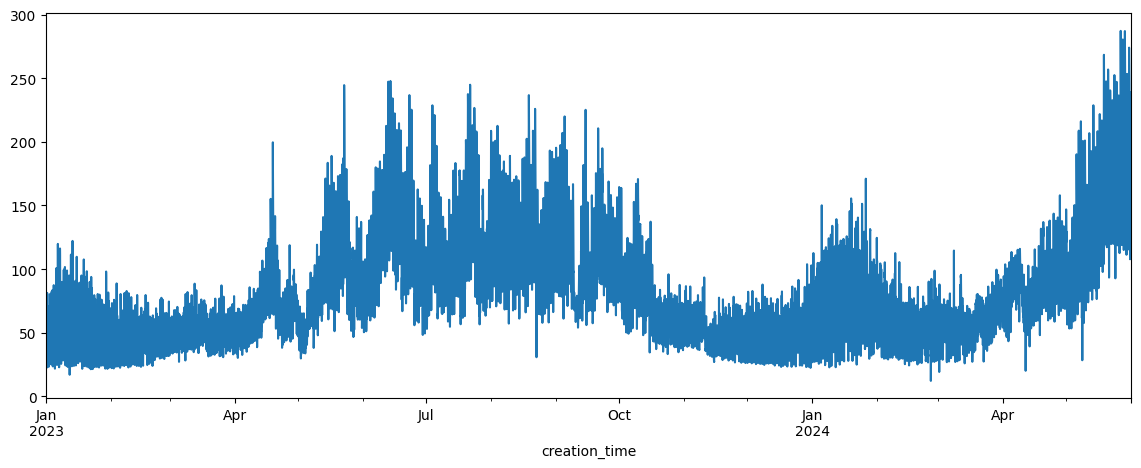

from_date:  2023-01-01 to_date:  2024-05-31
holidays_lst: [datetime.date(2023, 1, 1), datetime.date(2023, 1, 8), datetime.date(2023, 1, 14), datetime.date(2023, 1, 15), datetime.date(2023, 1, 22), datetime.date(2023, 1, 26), datetime.date(2023, 1, 29), datetime.date(2023, 2, 5), datetime.date(2023, 2, 12), datetime.date(2023, 2, 19), datetime.date(2023, 2, 26), datetime.date(2023, 3, 5), datetime.date(2023, 3, 8), datetime.date(2023, 3, 12), datetime.date(2023, 3, 19), datetime.date(2023, 3, 26), datetime.date(2023, 4, 2), datetime.date(2023, 4, 7), datetime.date(2023, 4, 9), datetime.date(2023, 4, 16), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 7), datetime.date(2023, 5, 14), datetime.date(2023, 5, 21), datetime.date(2023, 5, 28), datetime.date(2023, 6, 4), datetime.date(2023, 6, 11), datetime.date(2023, 6, 18), datetime.date(2023, 6, 25), datetime.date(2023, 6, 28), 

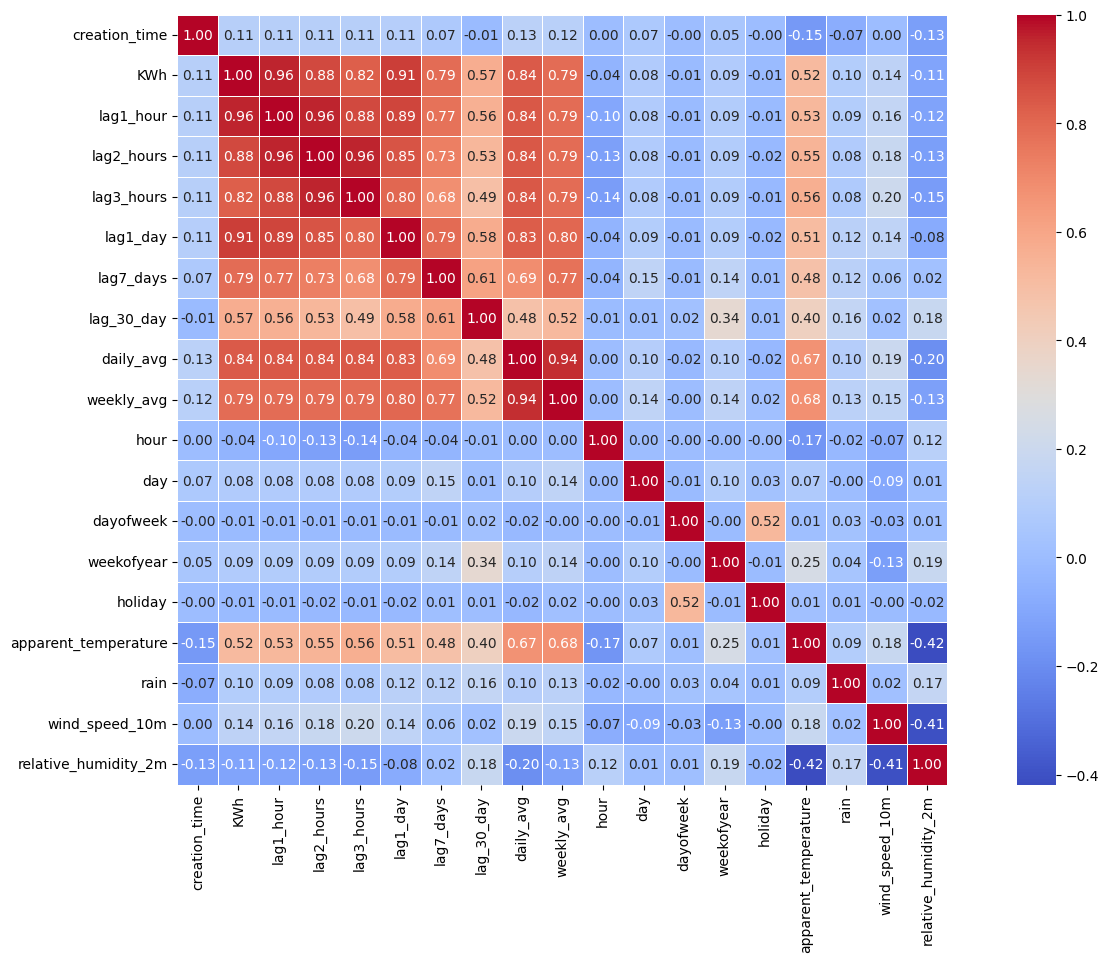

0


,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,38.125,52.650,62.125,61.600,39.900,32.575,40.250,52.130208,49.703720,1,31,1,5,0,9.85,0.0,10.10,95.0
2023-01-31 02:00:00,31.875,45.475,58.200,62.225,37.500,28.975,36.200,52.013021,49.712351,2,31,1,5,0,9.80,0.0,10.90,95.0
2023-01-31 02:30:00,25.875,38.125,52.650,62.125,34.150,25.875,31.500,51.840625,49.712351,2,31,1,5,0,10.60,0.0,11.40,93.5
2023-01-31 03:00:00,23.675,31.875,45.475,58.200,31.950,24.425,27.275,51.668229,49.710119,3,31,1,5,0,11.40,0.0,11.90,92.0
2023-01-31 03:30:00,22.700,25.875,38.125,52.650,26.975,23.650,25.600,51.579167,49.707292,3,31,1,5,0,12.65,0.0,11.30,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,184.975,151.325,159.275,184.225,161.525,167.600,107.425,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,205.225,162.250,156.950,173.100,176.150,173.500,110.800,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,228.850,184.975,151.325,159.275,192.775,186.175,108.525,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0


In [60]:

final_df = feature_engineering(pre_process(resample_df),c_matrix=True)

print(final_df.isna().sum().sum())
final_df.dropna(inplace=True)
# final_df.reset_index(drop=True, inplace=True)
final_df.set_index("creation_time",inplace=True)
# final_df.drop(['creation_time'],axis=1,inplace=True)
final_df


In [61]:
train_dataset = final_df.loc[~((final_df.index.month==5)& (final_df.index.year == 2024))]
# train_dataset.reset_index(drop=True,inplace=True)
train_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2023-01-31 01:30:00,38.125,52.650,62.125,61.600,39.900,32.575,40.250,52.130208,49.703720,1,31,1,5,0,9.85,0.0,10.10,95.0
2023-01-31 02:00:00,31.875,45.475,58.200,62.225,37.500,28.975,36.200,52.013021,49.712351,2,31,1,5,0,9.80,0.0,10.90,95.0
2023-01-31 02:30:00,25.875,38.125,52.650,62.125,34.150,25.875,31.500,51.840625,49.712351,2,31,1,5,0,10.60,0.0,11.40,93.5
2023-01-31 03:00:00,23.675,31.875,45.475,58.200,31.950,24.425,27.275,51.668229,49.710119,3,31,1,5,0,11.40,0.0,11.90,92.0
2023-01-31 03:30:00,22.700,25.875,38.125,52.650,26.975,23.650,25.600,51.579167,49.707292,3,31,1,5,0,12.65,0.0,11.30,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 21:30:00,128.975,110.375,84.675,82.250,123.725,97.225,67.500,102.390104,99.747024,21,30,1,18,0,19.05,0.0,10.85,23.5
2024-04-30 22:00:00,128.100,124.625,95.975,80.750,118.325,94.350,69.950,102.593750,99.847470,22,30,1,18,0,19.10,0.0,9.70,23.0
2024-04-30 22:30:00,124.750,128.975,110.375,84.675,111.075,94.325,73.550,102.878646,99.938021,22,30,1,18,0,18.40,0.0,12.35,24.0


In [62]:
val_dataset = final_df.loc[(final_df.index.month==5)& (final_df.index.year == 2024)]
# val_dataset.reset_index(drop=True,inplace=True)
val_dataset

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2024-05-01 00:00:00,140.975,128.375,128.100,124.625,122.475,80.800,85.4000,104.058854,100.418973,0,1,2,18,1,17.60,0.0,13.90,30.0
2024-05-01 00:30:00,146.900,136.200,124.750,128.975,126.150,82.150,82.6000,104.491146,100.611682,0,1,2,18,1,18.15,0.0,14.90,33.5
2024-05-01 01:00:00,146.700,140.975,128.375,128.100,127.200,84.200,79.3375,104.897396,100.797693,1,1,2,18,1,18.70,0.0,15.90,37.0
2024-05-01 01:30:00,142.825,146.900,136.200,124.750,127.000,87.275,76.2125,105.227083,100.963021,1,1,2,18,1,19.50,0.0,17.20,37.0
2024-05-01 02:00:00,138.175,146.700,140.975,128.375,126.750,89.425,77.9875,105.465104,101.108110,2,1,2,18,1,20.30,0.0,18.50,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,184.975,151.325,159.275,184.225,161.525,167.600,107.4250,192.109896,188.663988,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,205.225,162.250,156.950,173.100,176.150,173.500,110.8000,192.715625,188.758408,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,228.850,184.975,151.325,159.275,192.775,186.175,108.5250,193.467187,188.885417,22,31,4,22,0,27.80,0.0,8.65,16.0


In [23]:
lstm_model = model_training(train_dataset,val_dataset,model="DL")


dataset_features shape: (21888, 17)
dataset_label shape: (21888,)
dataset_features shape: (1488, 17)
dataset_label shape: (1488,)
(21888, 1, 17)
(1488, 1, 17)
Epoch 1/500
342/342 [==============================] - 5s 7ms/step - loss: 5569.3730 - val_loss: 17468.1934
Epoch 2/500
342/342 [==============================] - 1s 4ms/step - loss: 3451.9189 - val_loss: 14106.8242
Epoch 3/500
342/342 [==============================] - 1s 4ms/step - loss: 2511.9709 - val_loss: 11779.2783
Epoch 4/500
342/342 [==============================] - 1s 4ms/step - loss: 2015.8768 - val_loss: 10182.5166
Epoch 5/500
342/342 [==============================] - 1s 4ms/step - loss: 1723.7371 - val_loss: 8902.5400
Epoch 6/500
342/342 [==============================] - 1s 4ms/step - loss: 1320.1283 - val_loss: 7538.6826
Epoch 7/500
342/342 [==============================] - 1s 4ms/step - loss: 1088.0023 - val_loss: 6481.6279
Epoch 8/500
342/342 [==============================] - 1s 4ms/step - loss: 920.9847 - va

dataset_features shape: (1488, 17)
dataset_label shape: (1488,)
47/47 [==============================] - 0s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 13.909169002245827
Root Mean Squared Error (RMSE): 18.940669957642644
R-squared: 0.8582121121000952


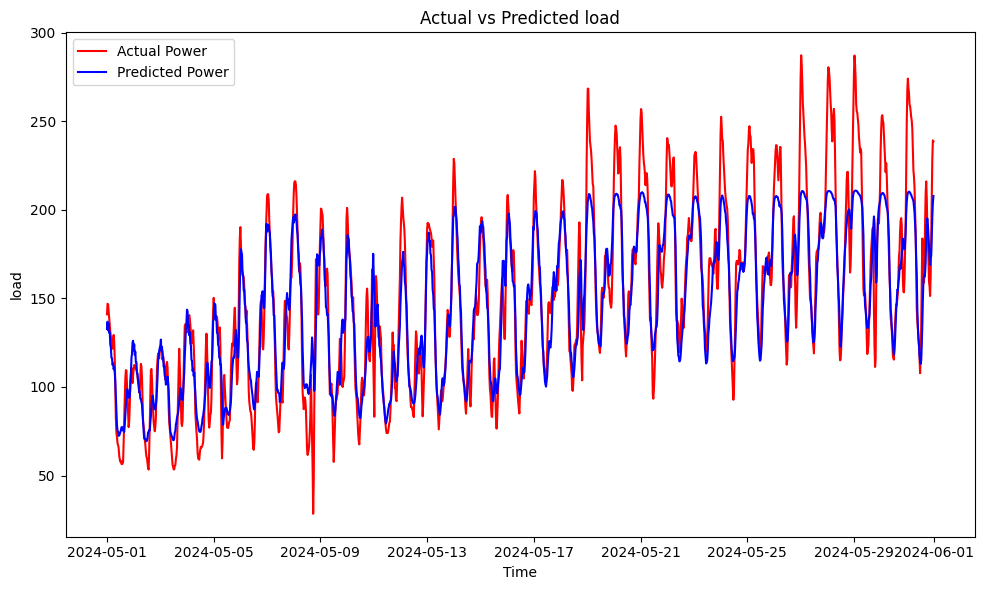

In [64]:

predicted_value = prediction(val_dataset,lstm_model)
# predicted_value = prediction(day_wise_prediction(val_dataset,29),lstm_model)


#### testing

In [65]:
test_df =data_ingestion(month=6)

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 12
Duplicated index: 0
null_values : 0
df rows after basic checks: 4355


null vlaues after resampling: 13
null values after filling: 0


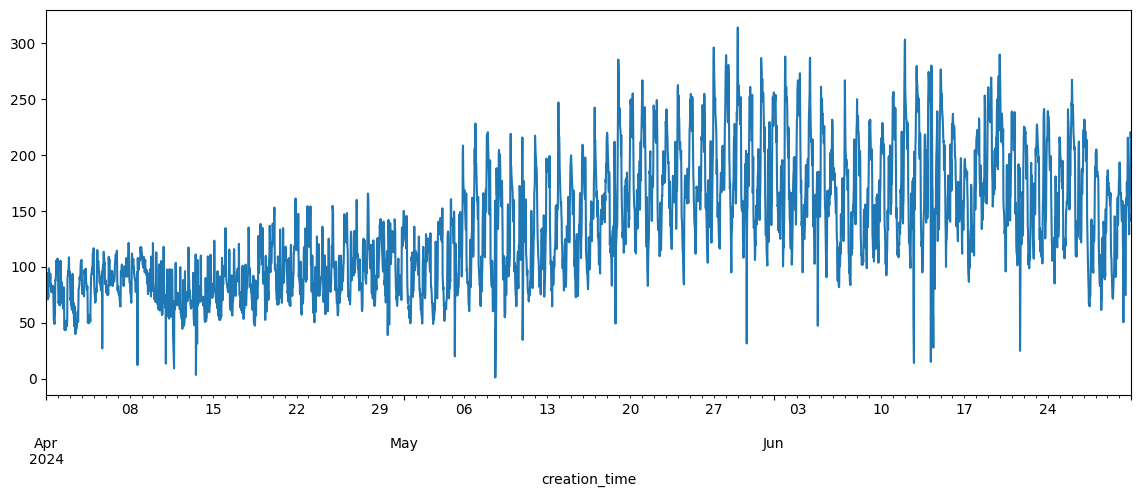

,KWh
creation_time,
2024-04-01 00:00:00,87.50
2024-04-01 00:30:00,73.30
2024-04-01 01:00:00,72.45
2024-04-01 01:30:00,71.60
2024-04-01 02:00:00,94.60
...,...
2024-06-30 21:30:00,164.20
2024-06-30 22:00:00,196.50
2024-06-30 22:30:00,220.60


In [66]:
main_df = pre_process(test_df)
main_df

In [67]:
final_df = feature_engineering(main_df)
final_df.set_index("creation_time",drop= True,inplace=True)
test_dataset = final_df.loc[final_df.index.month ==6]
test_dataset

from_date:  2024-04-01 to_date:  2024-06-30
holidays_lst: [datetime.date(2024, 4, 7), datetime.date(2024, 4, 10), datetime.date(2024, 4, 11), datetime.date(2024, 4, 14), datetime.date(2024, 4, 21), datetime.date(2024, 4, 28), datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30)]
creation_time              0
KWh                        0
lag1_hour                  2
lag2_hours                 4
lag3_hours                 6
lag1_day                  48
lag7_days                336
lag_30_day              1440
daily_avg                 47
weekly_avg               335
hour                       0
day                        0
dayofweek                  0
weekofyear                 0
holiday                    0
apparent_temperature       0
rain  

,KWh,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00,246.8,241.1,235.3,199.8,273.3,238.2,114.2,191.818750,189.175000,0,1,5,22,0,27.80,0.00,9.50,17.0
2024-06-01 00:30:00,256.0,226.1,252.0,228.3,255.6,249.9,110.6,191.827083,189.193155,0,1,5,22,0,29.60,0.00,11.95,15.5
2024-06-01 01:00:00,247.8,246.8,241.1,235.3,266.8,236.2,110.6,191.431250,189.227679,1,1,5,22,0,31.40,0.00,14.40,14.0
2024-06-01 01:30:00,245.2,256.0,226.1,252.0,267.8,254.6,112.2,190.960417,189.199702,1,1,5,22,0,32.80,0.00,15.40,15.0
2024-06-01 02:00:00,254.1,247.8,246.8,241.1,247.6,247.9,107.9,191.095833,189.218155,2,1,5,22,0,34.20,0.00,16.40,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 21:30:00,164.2,141.0,129.2,162.4,139.6,203.8,228.3,149.452083,152.128869,21,30,6,26,1,31.40,0.15,8.70,94.0
2024-06-30 22:00:00,196.5,171.9,147.0,148.2,162.1,213.8,235.3,150.168750,152.077381,22,30,6,26,1,31.80,0.10,5.20,94.0
2024-06-30 22:30:00,220.6,164.2,141.0,129.2,165.5,215.4,252.0,151.316667,152.092857,22,30,6,26,1,31.45,0.60,7.00,94.0


dataset_features shape: (1440, 17)
dataset_label shape: (1440,)
45/45 [==============================] - 0s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 21.639154703352183
Root Mean Squared Error (RMSE): 28.708699179904926
R-squared: 0.6495792968964217


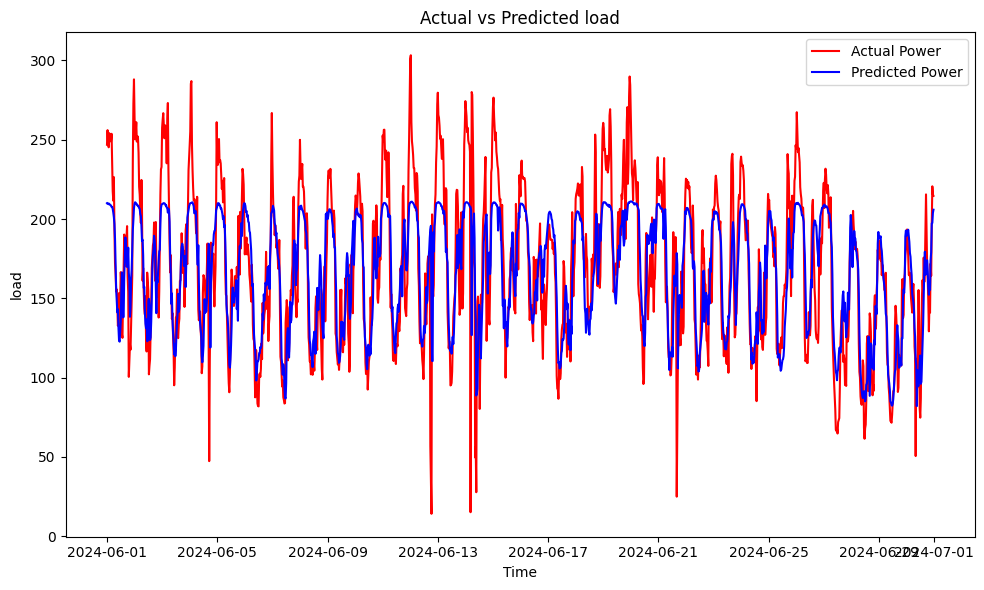

In [68]:
predicted = prediction(test_dataset,lstm_model)